Using TensorFlow backend.


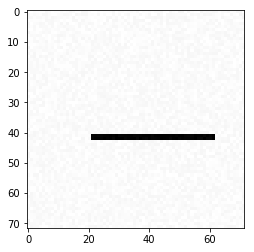

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.utils import np_utils
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [2]:
#Importing various methods for the rest of the TP

import keras
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, MaxPooling1D,Flatten,BatchNormalization,UpSampling2D,Input,Average,Add
from keras.layers import Conv1D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import normalize


In [3]:
#Generating training data for classification problem

[X_train,Y_train] = generate_dataset_classification(300,20)
print(X_train[0].shape)
print(Y_train[0].shape)
#print(Y_train)
Y_train = to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
(5184,)
()


## 3 - Simple Classification

The next two cells build the simplest network for the task : One fully connected (FC) layer with 3 neurons. The first cell optimizes the network with SGD, the second cell optimizes the network with ADAM, and then evaluates it on a test example. I used 100 epochs for optimization, but that may be a bit overkill.

Optimization using ADAM converges faster than optimization using SGD.




In [4]:
#Code for Question 3. Training using SGD first, and then ADAM in the next cell.

classifier = Sequential()
classifier.add(Dense(3,activation = 'softmax',input_shape=(5184,)))
  


sgd =SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

classifier.fit(X_train,Y_train,batch_size=32,epochs=100,verbose=1)




Epoch 1/100
300/300 [==============================] - 1s 5ms/step - loss: 1.3910 - acc: 0.4567
Epoch 2/100
300/300 [==============================] - 0s 267us/step - loss: 0.7831 - acc: 0.6633
Epoch 3/100
300/300 [==============================] - 0s 257us/step - loss: 0.4969 - acc: 0.8033
Epoch 4/100
300/300 [==============================] - 0s 297us/step - loss: 0.4151 - acc: 0.8500
Epoch 5/100
300/300 [==============================] - 0s 253us/step - loss: 0.3289 - acc: 0.9300
Epoch 6/100
300/300 [==============================] - 0s 240us/step - loss: 0.2741 - acc: 0.9467
Epoch 7/100
300/300 [==============================] - 0s 270us/step - loss: 0.2811 - acc: 0.9267
Epoch 8/100
300/300 [==============================] - 0s 277us/step - loss: 0.2626 - acc: 0.9367
Epoch 9/100
300/300 [==============================] - 0s 270us/step - loss: 0.2089 - acc: 0.9433
Epoch 10/100
300/300 [==============================] - 0s 293us/step - loss: 0.1974 - acc: 0.9367
Epoch 11/100
300/300 

300/300 [==============================] - 0s 513us/step - loss: 0.0324 - acc: 0.9967
Epoch 84/100
300/300 [==============================] - 0s 467us/step - loss: 0.0314 - acc: 0.9967
Epoch 85/100
300/300 [==============================] - 0s 393us/step - loss: 0.0320 - acc: 1.0000
Epoch 86/100
300/300 [==============================] - 0s 307us/step - loss: 0.0326 - acc: 0.9967
Epoch 87/100
300/300 [==============================] - 0s 453us/step - loss: 0.0310 - acc: 1.0000
Epoch 88/100
300/300 [==============================] - 0s 267us/step - loss: 0.0311 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 0s 330us/step - loss: 0.0293 - acc: 1.0000
Epoch 90/100
300/300 [==============================] - 0s 290us/step - loss: 0.0301 - acc: 0.9967
Epoch 91/100
300/300 [==============================] - 0s 443us/step - loss: 0.0310 - acc: 1.0000
Epoch 92/100
300/300 [==============================] - 0s 350us/step - loss: 0.0287 - acc: 1.0000
Epoch 93/100
300/300 [=

In [5]:
#Same network, training using ADAM. Converges faster.

classifier = Sequential()
classifier.add(Dense(3,activation = 'softmax',input_shape=(5184,)))



classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
classifier.fit(X_train,Y_train,batch_size=32,epochs=100,verbose=1)


X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(classifier.predict(X_test)) #Is correct if output is [0,1,0], which corresponds the the one-hot encoding for the disk class.




Epoch 1/100
300/300 [==============================] - 1s 2ms/step - loss: 1.9390 - acc: 0.4167
Epoch 2/100
300/300 [==============================] - 0s 687us/step - loss: 0.9289 - acc: 0.6067
Epoch 3/100
300/300 [==============================] - 0s 827us/step - loss: 0.6235 - acc: 0.7533
Epoch 4/100
300/300 [==============================] - 0s 820us/step - loss: 0.4983 - acc: 0.8067
Epoch 5/100
300/300 [==============================] - 0s 857us/step - loss: 0.3723 - acc: 0.8567
Epoch 6/100
300/300 [==============================] - 0s 690us/step - loss: 0.2959 - acc: 0.8967
Epoch 7/100
300/300 [==============================] - 0s 500us/step - loss: 0.3083 - acc: 0.8667
Epoch 8/100
300/300 [==============================] - 0s 550us/step - loss: 0.2279 - acc: 0.9367
Epoch 9/100
300/300 [==============================] - 0s 673us/step - loss: 0.2604 - acc: 0.8867
Epoch 10/100
300/300 [==============================] - 0s 930us/step - loss: 0.1871 - acc: 0.9467
Epoch 11/100
300/300 

300/300 [==============================] - 0s 467us/step - loss: 0.0104 - acc: 1.0000
Epoch 84/100
300/300 [==============================] - 0s 410us/step - loss: 0.0102 - acc: 1.0000
Epoch 85/100
300/300 [==============================] - 0s 363us/step - loss: 0.0098 - acc: 1.0000
Epoch 86/100
300/300 [==============================] - 0s 370us/step - loss: 0.0094 - acc: 1.0000
Epoch 87/100
300/300 [==============================] - 0s 360us/step - loss: 0.0090 - acc: 1.0000
Epoch 88/100
300/300 [==============================] - 0s 317us/step - loss: 0.0090 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 0s 417us/step - loss: 0.0089 - acc: 1.0000
Epoch 90/100
300/300 [==============================] - 0s 383us/step - loss: 0.0087 - acc: 1.0000
Epoch 91/100
300/300 [==============================] - 0s 287us/step - loss: 0.0089 - acc: 1.0000
Epoch 92/100
300/300 [==============================] - 0s 497us/step - loss: 0.0084 - acc: 1.0000
Epoch 93/100
300/300 [=

## 4 - Visualisation of the solution

The cell below allows us to visualise the weights in our trained three-neuron network. You should use the ADAM-trained network for clearer visualisation.

We can clearly see a square, circle and triangle in the center of each weight matrix. This means each neuron specializes in recognizing a specific shape.

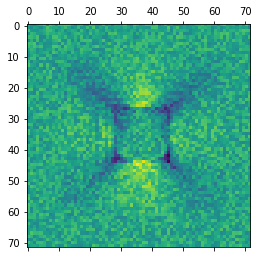

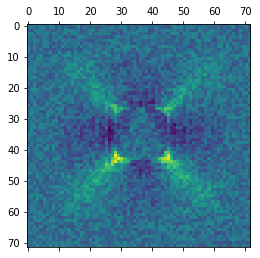

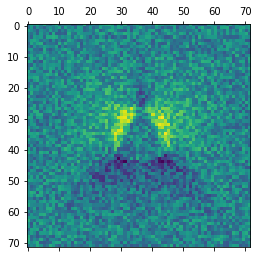

In [6]:
Weights = classifier.get_weights()


for i in range(3):
    W_1 = np.reshape(Weights[0][:,i],(72,72))
    plt.matshow(W_1)

## 5 - A more difficult classification problem

The cell below generates a new training set where the figures are allowed to move.

In [7]:
#Generating new training set

[X_train_2, Y_train_2] = generate_dataset_classification(300, 20, True)
Y_train_2 = to_categorical(Y_train_2)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


The cell below retrains our simple, three-neuron network on the new dataset. As you might expect, the structure of this simple network is not complex enough to differentiate between moving shapes and obtain decent performance.

In [8]:
#Training our old network on the new dataset

classifier_2 = Sequential()
classifier_2.add(Dense(3,activation = 'softmax',input_shape=(5184,)))



classifier_2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

classifier_2.fit(X_train_2,Y_train_2,batch_size=32,epochs=100,verbose=1)



Epoch 1/100
300/300 [==============================] - 0s 1ms/step - loss: 2.3854 - acc: 0.2900
Epoch 2/100
300/300 [==============================] - 0s 447us/step - loss: 1.5855 - acc: 0.3567
Epoch 3/100
300/300 [==============================] - 0s 490us/step - loss: 1.2183 - acc: 0.4200
Epoch 4/100
300/300 [==============================] - 0s 483us/step - loss: 1.3649 - acc: 0.3667
Epoch 5/100
300/300 [==============================] - 0s 437us/step - loss: 1.3043 - acc: 0.4133
Epoch 6/100
300/300 [==============================] - 0s 463us/step - loss: 1.0173 - acc: 0.4833
Epoch 7/100
300/300 [==============================] - 0s 483us/step - loss: 1.0311 - acc: 0.5233
Epoch 8/100
300/300 [==============================] - 0s 407us/step - loss: 1.0244 - acc: 0.5267
Epoch 9/100
300/300 [==============================] - 0s 483us/step - loss: 1.0703 - acc: 0.4800
Epoch 10/100
300/300 [==============================] - 0s 570us/step - loss: 1.0139 - acc: 0.5400
Epoch 11/100
300/300 

300/300 [==============================] - 0s 400us/step - loss: 0.5241 - acc: 0.7767
Epoch 84/100
300/300 [==============================] - 0s 377us/step - loss: 0.5556 - acc: 0.7733
Epoch 85/100
300/300 [==============================] - 0s 397us/step - loss: 0.4529 - acc: 0.8333
Epoch 86/100
300/300 [==============================] - 0s 317us/step - loss: 0.6047 - acc: 0.7233
Epoch 87/100
300/300 [==============================] - 0s 433us/step - loss: 0.5371 - acc: 0.7533
Epoch 88/100
300/300 [==============================] - 0s 397us/step - loss: 0.5246 - acc: 0.7867
Epoch 89/100
300/300 [==============================] - 0s 393us/step - loss: 0.4760 - acc: 0.7967
Epoch 90/100
300/300 [==============================] - 0s 397us/step - loss: 0.5193 - acc: 0.7567
Epoch 91/100
300/300 [==============================] - 0s 317us/step - loss: 0.6626 - acc: 0.7133
Epoch 92/100
300/300 [==============================] - 0s 447us/step - loss: 0.6519 - acc: 0.6900
Epoch 93/100
300/300 [=

In [9]:
#Evaluating our old network on the new dataset

[X_test, Y_test] = generate_test_set_classification()

classifier_2.evaluate(X_test,Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 297us/step


[0.8844381165504456, 0.5833333341280619]

We can see with the evaluation that our old network does not perform well on this task (less than 60% accuracy), because its structure is too simple to account for the complexity of the data.

We are going to build a convolutional network in the cell below to tackle this new task.
This network consists of 2 convolutional layers with 16 features, 5x5 kernel size, a batch normalization layer after each convolutional layer, (so that the output of these layers is more affected by the non-linearity of the activation function),  a MaxPooling layer, a flattening layer, an FC layer with 64 neurons,and finally an output layer with 3 neurons, with the softmax activation function.





In [10]:
#Getting a new, larger training dataset to train our convolutional network;
[X_train_2,Y_train_2] = generate_dataset_classification(600,20,True)
Y_train_2 = to_categorical(Y_train_2)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590


In [11]:
#Building our new convolutional network

convolutional_classifier = Sequential()
convolutional_classifier.add(Conv2D(32,(5,5),activation='relu',input_shape=(72,72,1)))
convolutional_classifier.add(BatchNormalization())
convolutional_classifier.add(Conv2D(32,(5,5),activation='relu'))
convolutional_classifier.add(BatchNormalization())
convolutional_classifier.add(MaxPooling2D(pool_size=(2,2)))
convolutional_classifier.add(Flatten())
convolutional_classifier.add(Dense(64,activation='relu'))
convolutional_classifier.add(Dense(3,activation='softmax'))


#We need to reshape the inputs for use by the 2D-convolutional layer
X_train_reshaped = np.zeros((600,72,72))
X_test_reshaped =  np.zeros((300,72,72))
for i in range(len(X_train_2)):
    X_train_reshaped[i] = np.reshape(X_train_2[i],(72,72))
for i in range(300):    
    X_test_reshaped[i] = np.reshape(X_test[i],(72,72))
    
X_train_reshaped = X_train_reshaped.reshape(600,72,72,1)
X_test_reshaped = X_test_reshaped.reshape(300,72,72,1)

print(X_train_reshaped.shape)

#Compiling and Training
convolutional_classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

convolutional_classifier.fit(X_train_reshaped,Y_train_2,batch_size=32,epochs=100,verbose=1)
#May take a minute or so to train, reduce the number of epochs to 50 if it takes too long.
#I used 100 epochs for the comparison with the previous network

(600, 72, 72, 1)
Epoch 1/100
600/600 [==============================] - 3s 6ms/step - loss: 1.6843 - acc: 0.6067
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 0.7185 - acc: 0.7600
Epoch 3/100
600/600 [==============================] - 1s 1ms/step - loss: 0.4129 - acc: 0.8417
Epoch 4/100
600/600 [==============================] - 1s 1ms/step - loss: 0.2438 - acc: 0.9150
Epoch 5/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1204 - acc: 0.9533
Epoch 6/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0651 - acc: 0.9717
Epoch 7/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0358 - acc: 0.9833
Epoch 8/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0372 - acc: 0.9850
Epoch 9/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0196 - acc: 0.9933
Epoch 10/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0106 - acc: 0.9950
Epoch 11/100
600/600 [

600/600 [==============================] - 1s 2ms/step - loss: 3.2876e-05 - acc: 1.0000A: 0s - loss: 4.1959e-05 - ac
Epoch 83/100
600/600 [==============================] - 1s 2ms/step - loss: 3.1547e-05 - acc: 1.0000
Epoch 84/100
600/600 [==============================] - 1s 2ms/step - loss: 4.0314e-05 - acc: 1.0000
Epoch 85/100
600/600 [==============================] - 1s 2ms/step - loss: 4.9329e-05 - acc: 1.0000
Epoch 86/100
600/600 [==============================] - 1s 2ms/step - loss: 3.6521e-05 - acc: 1.0000
Epoch 87/100
600/600 [==============================] - 1s 2ms/step - loss: 4.0965e-05 - acc: 1.0000
Epoch 88/100
600/600 [==============================] - 1s 2ms/step - loss: 3.1171e-05 - acc: 1.0000
Epoch 89/100
600/600 [==============================] - 1s 2ms/step - loss: 6.5923e-05 - acc: 1.0000
Epoch 90/100
600/600 [==============================] - 1s 2ms/step - loss: 2.6318e-05 - acc: 1.0000
Epoch 91/100
600/600 [==============================] - 1s 2ms/step - loss:

In [12]:
#Testing our new convolutional network

convolutional_classifier.evaluate(X_test_reshaped,Y_test)

300/300 [==============================] - 0s 1ms/step


[0.819410994052887, 0.8566666658719381]

We can see that the results of this network are much better, achieving between 87~90% accuracy.


## 6 -  A regression problem


I tried a lot of different normalizations and network architectures, but couldn't find a way to normalize Y_test and Y_train to make the network work.

It's worth noting that the network works well when the triangles don't have their location randomized.
The network also gives good performance on the traning set when the triangles have random locations, but this performance doesn't extend to the testing set unfortunately.

In [13]:
#Generating training data

[X_train,Y_train] = generate_dataset_regression(300,20)
[X_test,Y_test] = generate_test_set_regression()


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


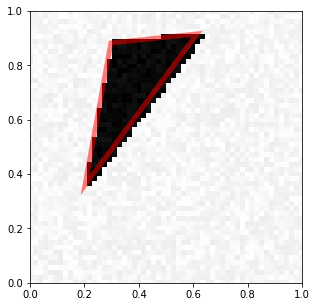

(5184,)


In [14]:
#Visualization of a training example
visualize_prediction(X_train[0],Y_train[0])
print(X_train[0].shape)



In [15]:
#Building a regressor network


#Reshape our data first

X_train_reshaped = np.zeros((300,72,72))
X_test_reshaped =  np.zeros((300,72,72))
for i in range(300):
    X_train_reshaped[i] = np.reshape(X_train[i],(72,72))
for i in range(300):
    X_test_reshaped[i] = np.reshape(X_test[i],(72,72))
    
X_train_reshaped = X_train_reshaped.reshape(300,72,72,1)
X_test_reshaped = X_test_reshaped.reshape(300,72,72,1)




regressor=Sequential()
regressor.add(Conv2D(32,(3,3),activation='relu',input_shape=(72,72,1)))
regressor.add(Conv2D(16,(3,3),activation='relu'))
regressor.add(Flatten())
regressor.add(Dense(128,activation='relu'))
regressor.add(Dense(64,activation='relu'))
regressor.add(Dense(64,activation='relu'))
regressor.add(Dense(64,activation='relu'))
regressor.add(Dense(6))


regressor.compile(loss='mean_absolute_error',optimizer='adam')
regressor.fit(X_train_reshaped,Y_train,batch_size=32,epochs=100,verbose=1)




regressor.evaluate(X_test_reshaped,Y_test)

Epoch 1/100
300/300 [==============================] - 1s 5ms/step - loss: 0.4966
Epoch 2/100
300/300 [==============================] - 0s 2ms/step - loss: 0.2632
Epoch 3/100
300/300 [==============================] - 0s 2ms/step - loss: 0.2400
Epoch 4/100
300/300 [==============================] - 0s 2ms/step - loss: 0.2127
Epoch 5/100
300/300 [==============================] - 0s 2ms/step - loss: 0.1986
Epoch 6/100
300/300 [==============================] - 0s 2ms/step - loss: 0.1831
Epoch 7/100
300/300 [==============================] - 0s 2ms/step - loss: 0.1712
Epoch 8/100
300/300 [==============================] - 0s 2ms/step - loss: 0.1666
Epoch 9/100
300/300 [==============================] - 0s 2ms/step - loss: 0.1546
Epoch 10/100
300/300 [==============================] - 0s 2ms/step - loss: 0.1343
Epoch 11/100
300/300 [==============================] - 0s 2ms/step - loss: 0.1210
Epoch 12/100
300/300 [==============================] - 0s 2ms/step - loss: 0.1085
Epoch 13/100


300/300 [==============================] - 1s 2ms/step - loss: 0.0311
Epoch 100/100
300/300 [==============================] - 0s 943us/step


0.22525093376636504

300/300 [==============================] - 0s 527us/step
0.22525093376636504


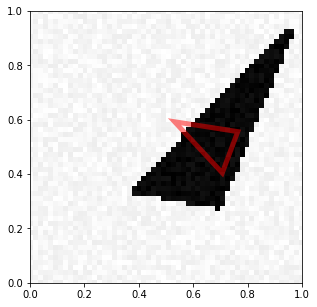

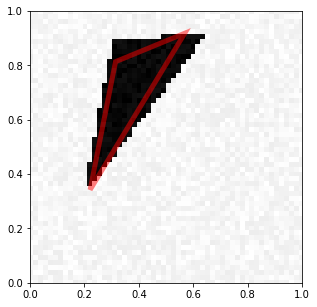

In [16]:
#Evaluating our network. Doesn't work well unfortunately
print(regressor.evaluate(X_test_reshaped,Y_test))


Test_visu = X_test[0].reshape(1,72,72,1)
Test_visu_2 = X_train[0].reshape(1,72,72,1)
visualize_prediction(X_test[0],regressor.predict(Test_visu)) #Testing example visualization : poor results
plt.figure()
visualize_prediction(X_train[0],regressor.predict(Test_visu_2)) #Training example visualization : decent results

## 7 - Image Denoising

The cell below implements functions to generate noisy/clean image pairs, for training and testing our denoising network. The noise amplitude is random, and is chosen between 20 and 50.

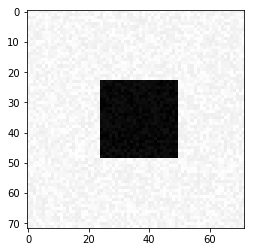

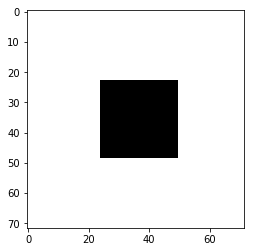

In [17]:
#Rewriting the generate_a_* functions to generate a noisy/clean image pair. Noise has random amplitude (between 20 and 30).

def generate_a_rectangle_noisy(free_location=False):
    noise=np.random.randint(20,50)
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize,U,V)


def generate_a_disk_noisy(free_location=False):
    noise=np.random.randint(20,50)
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize,U,V)

def generate_a_triangle_noisy(free_location=False):
    noise=np.random.randint(20,50)
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize,U,V)

#Testing

Testim = generate_a_rectangle_noisy()

plt.imshow(Testim[0].reshape(72,72),cmap='gray')

plt.figure()
plt.imshow(Testim[1].reshape(72,72),cmap='gray')



In [18]:
#defining noisy dataset generation

def generate_noisy_dataset(nb_samples,free_location):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i],Y[i] = generate_a_rectangle_noisy(free_location)
        elif category == 1: 
            X[i],Y[i] = generate_a_disk_noisy(free_location)
        else:
            X[i],Y[i] = generate_a_triangle_noisy(free_location)
       
    print("Done")
    X =  X  / 255
    return [X, Y]

#Generating noisy training set, and noisy testing set
[X_noisy_train,Y_noisy_train] = generate_noisy_dataset(600,True)



[X_noisy_test,Y_noisy_test] = generate_noisy_dataset(300,True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
Done
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Done


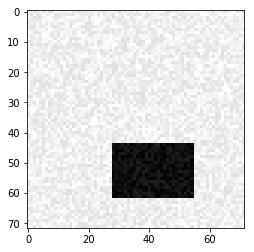

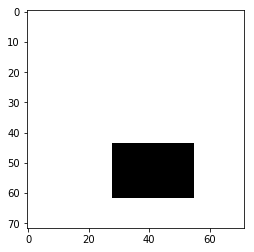

In [19]:
#Check out the data is right 

plt.imshow(X_noisy_train[0].reshape(72,72),cmap='gray')
plt.figure()
plt.imshow(Y_noisy_train[0].reshape(72,72),cmap='gray')


We build our hourglass network in the cell below. If it does not seem to converge, please try to train it again. It has gotten stuck once (only once) for me before.

In [20]:


#Reshaping our data for use by the hourglass denoising network.

X_noisy_train_reshaped = np.zeros((600,72,72))
#X_noisy_test_reshaped =  np.zeros((300,72,72))
Y_noisy_train_reshaped = np.zeros((600,72,72))
for i in range(600):
    X_noisy_train_reshaped[i] = np.reshape(X_noisy_train[i],(72,72))
    #X_noisy_test_reshaped[i] = np.reshape(X_noisy_test[i],(72,72))
    Y_noisy_train_reshaped[i] = np.reshape(Y_noisy_train[i],(72,72))
X_noisy_train_reshaped = X_noisy_train_reshaped.reshape(600,72,72,1)
Y_noisy_train_reshaped = Y_noisy_train_reshaped.reshape(600,72,72,1)

#Building the convolutional hourglass denoising network. 


inputs=Input(shape=(72,72,1))

conv1 = Conv2D(32,(3,3),activation='relu',padding='same')(inputs)
conv1 = Conv2D(32,(3,3),activation='relu',padding='same')(conv1)
conv2 = MaxPooling2D((2,2))(conv1)
conv2 = Conv2D(32,(3,3),activation='relu',padding='same')(conv2)
conv2 = Conv2D(32,(3,3),activation='relu',padding='same')(conv2)
conv3 = MaxPooling2D((2,2))(conv2)
conv3 = Conv2D(32,(3,3),activation='relu',padding='same')(conv3)
conv3 = Conv2D(32,(3,3),activation='relu',padding='same')(conv3)
conv3 = UpSampling2D((2,2))(conv3)
conv4 = Add()([conv2,conv3]) #skip-connection
conv4 = Conv2D(32,(3,3),activation='relu',padding='same')(conv4)
conv4 = Conv2D(32,(3,3),activation='relu',padding='same')(conv4)
conv4 = UpSampling2D((2,2))(conv4)
conv5 = Add()([conv1,conv4]) #second skip-connection
conv5 = Conv2D(32,(3,3),activation='relu',padding='same')(conv5)
convfinal = Conv2D(1,(3,3),activation='relu',padding='same')(conv5) #output layer
predictions = convfinal

denoiser=Model(inputs=inputs,outputs=predictions)



denoiser.compile(loss='mean_squared_error',optimizer='adam')

denoiser.fit(X_noisy_train_reshaped,Y_noisy_train_reshaped,batch_size=32,epochs=100)





Epoch 1/100
600/600 [==============================] - 2s 4ms/step - loss: 37447.6998
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 6996.4008
Epoch 3/100
600/600 [==============================] - 1s 2ms/step - loss: 3666.3971
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 2307.1223
Epoch 5/100
600/600 [==============================] - 1s 2ms/step - loss: 1505.4874
Epoch 6/100
600/600 [==============================] - 1s 2ms/step - loss: 1037.7952
Epoch 7/100
600/600 [==============================] - 1s 2ms/step - loss: 725.6533
Epoch 8/100
600/600 [==============================] - 1s 2ms/step - loss: 510.9988
Epoch 9/100
600/600 [==============================] - 1s 2ms/step - loss: 392.4013
Epoch 10/100
600/600 [==============================] - 1s 2ms/step - loss: 313.0724
Epoch 11/100
600/600 [==============================] - 1s 2ms/step - loss: 246.5107
Epoch 12/100
600/600 [==============================] - 1s 2ms/step

600/600 [==============================] - 1s 2ms/step - loss: 19.3338
Epoch 99/100
600/600 [==============================] - 1s 2ms/step - loss: 22.3367
Epoch 100/100
600/600 [==============================] - 1s 2ms/step - loss: 21.2454


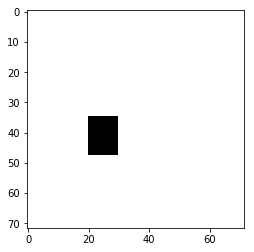

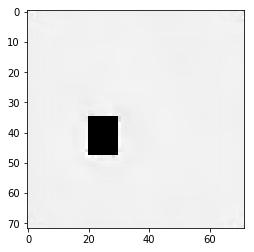

In [21]:
Predict = denoiser.predict(X_noisy_test[1].reshape(1,72,72,1))

plt.imshow(Y_noisy_test[1].reshape(72,72),cmap='gray')
plt.figure()
plt.imshow(Predict.reshape(72,72),cmap='gray')

It works pretty well. Using convolutional layers on a flat white background has the unfortunate effect of turning the background grey, which is very visible to the eye even if the L2-norm difference is quite small mathematically. 

This effect can be reduced by training with more epochs/making the network larger/increasing the size of the training set or diminishing the amplitude of the random noise, but I kept the network to the dimensions you see here for the sake of keeping a reasonable training time.